# Optimal Growth - RBC with Tax (Coleman 1991)

In [1]:
import tensorflow as tf
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import datetime
from typing import Tuple
class Vector: pass

2023-01-26 02:30:01.356352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
# Model parameters
β = 0.99
α = 0.36
δ = 0.025
σ = 2.0
τ = 0.1
Kss = ((1/β+δ-1)/(α*(1-τ)))**(1/(α-1))
Iss = δ*Kss;
Imin = phi*Iss;
print(Kss, Iss)

xmin=Kss*0.8
xmax=Kss*1.2
min_FB = lambda a,b: a+b-tf.sqrt(a**2+b**2)
layers = [
    tf.keras.layers.Normalization(axis=-1, input_dim=1, mean=0, variance=1, invert=False),
    tf.keras.layers.Dense(32, activation='leaky_relu',  bias_initializer='he_uniform'),
    tf.keras.layers.Dense(32, activation='leaky_relu',  bias_initializer='he_uniform'),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
]
perceptron = tf.keras.Sequential(layers)

def model(x:Vector)->Tuple[Vector]:
    sh = perceptron(x)
    return sh

λ=1
xvec = np.power(np.linspace(xmin**(1/λ),xmax**(1/λ),200,dtype='float32'),λ).reshape(-1,1)
#print(xvec)
print(xvec.shape, model(xvec).shape)
#plt.plot(xvec, model(xvec), label = 'c(x)')

32.22290426894504 0.805572606723626
(200, 1) (200, 1)


In [5]:
def residuals(k:Vector):
    c=model(k)
    kp=k**α+(1-δ)*k-c
    cp=model(kp)
    R=min_FB(k**α+(1-δ)*k-c,c**(-σ)-β*cp**(-σ)*((1-τ)*α*kp**(α-1)+1-δ))
    return R

#print(residuals(xvec));

def J(n):
    x = tf.random.uniform(shape=(n,1),minval=xmin,maxval=xmax)
    R = residuals(x)
    R_squared = R*R
    return tf.reduce_mean(R_squared)

n = 500
v = J(n)
v.numpy()

0.009064411

In [6]:
θ = perceptron.trainable_variables
print(str(θ)[:1000])

[<tf.Variable 'dense_3/kernel:0' shape=(1, 32) dtype=float32, numpy=
array([[ 0.31054646, -0.14417109, -0.02310696,  0.0612835 ,  0.20993066,
        -0.03997341, -0.39792895,  0.03064451,  0.31592917, -0.25612962,
         0.15116078,  0.2514717 ,  0.20749575,  0.02501741, -0.41554058,
        -0.33238032,  0.36073142, -0.42551628, -0.03516611, -0.23744895,
         0.28821176, -0.3169527 , -0.23278214,  0.3778739 ,  0.3747934 ,
         0.15135556, -0.06363198,  0.24351442,  0.17736596,  0.31220895,
         0.4035552 , -0.1836979 ]], dtype=float32)>, <tf.Variable 'dense_3/bias:0' shape=(32,) dtype=float32, numpy=
array([-0.42574543, -0.10737574, -0.26281202,  0.21269408,  0.42813656,
        0.31367412, -0.2128    ,  0.19562158,  0.3598657 ,  0.42755374,
        0.09294644, -0.34304982, -0.18077835, -0.3653136 , -0.40448537,
       -0.41410562,  0.38133183,  0.17016122,  0.07894662,  0.23970845,
        0.3635256 ,  0.07771465,  0.21699592,  0.37439987, -0.13301343,
       -0.153449

In [19]:
from tensorflow.keras.optimizers import Adam, SGD
variables = perceptron.trainable_variables
optimizer = Adam()
optimizer.lr.assign(0.0000001)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-07>

In [20]:
@tf.function
def training_step():
    
    with tf.GradientTape() as tape:
        xx = J(n)
        
    grads = tape.gradient(xx,θ)
    optimizer.apply_gradients(zip(grads,θ))
    return xx

def train_me(K):
    vals=[]
    for k in tqdm(tf.range(K)):
        val=training_step()
        vals.append(val.numpy())
    return vals

In [12]:
results = train_me(150000)

  0%|                                                | 0/150000 [00:00<?, ?it/s]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


100%|██████████████████████████████████| 150000/150000 [05:22<00:00, 465.33it/s]


In [21]:
results = train_me(500)

100%|████████████████████████████████████████| 500/500 [00:02<00:00, 243.57it/s]


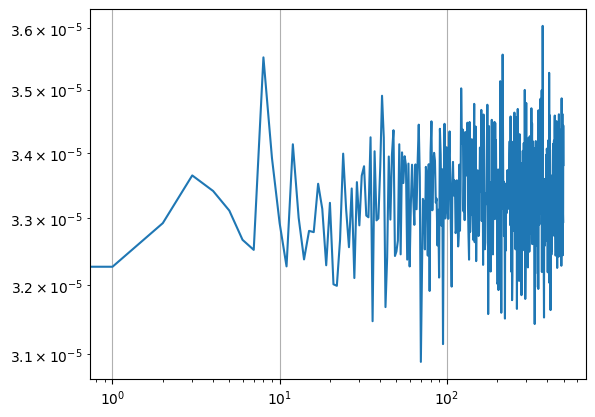

In [22]:
plt.plot(np.sqrt(results))
plt.xscale('log')
plt.yscale('log')
plt.grid()

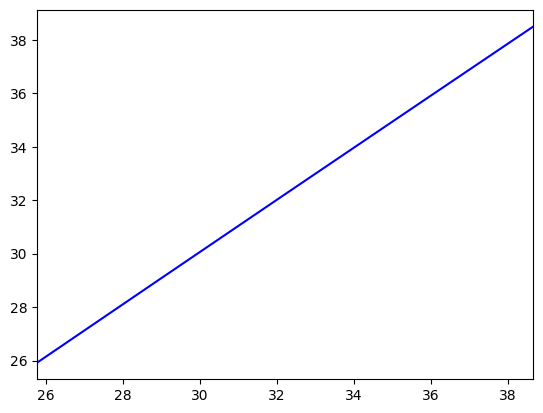

In [23]:
plt.plot(xvec,(xvec**α+(1-δ)*xvec)-model(xvec),label='Solved c(x)',c='b')
plt.xlim([xmin,xmax])
plt.show()

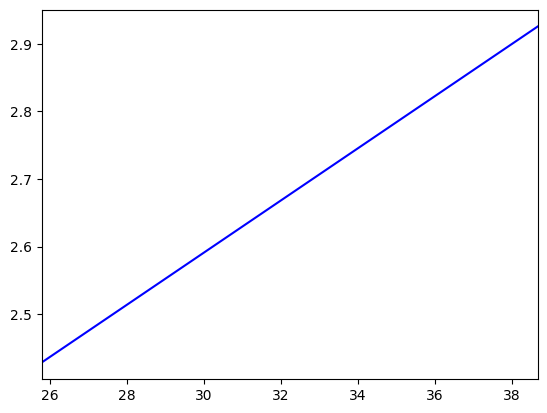

In [24]:
plt.plot(xvec,model(xvec),label='Solved c(x)',c='b')
plt.xlim([xmin,xmax])
plt.show()